## Initialization

In [8]:
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import os
import warnings
import pandas as pd
from fpdf import FPDF
import cairosvg
from IPython.display import SVG, display


In [9]:
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, f'Evaluation of {species}', 0, 1, 'C')

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')


In [10]:
species = "mCorTow1"
corrected = False
source = "VGP"
gene = "IGH"

#chr1_min = 36738790
#chr1_max = 38775860
#chr2_min = 31557979
#chr2_max = 33620776

In [11]:
!mkdir ../errorPlots/{species}

mkdir: cannot create directory '../errorPlots/mCorTow1': File exists


## Coverage Break Analysis

In [12]:
def parse_read_bases(read_bases):
    """
    Parse read bases to count correct matches (., and ,) while correctly handling indels,
    read starts (^), read ends ($), and skipping over sequences indicating indels (+nXXX or -nXXX).
    """
    # Remove read start markers (^) along with the following character indicating mapping quality
    cleaned_bases = re.sub(r'\^.', '', read_bases)

    # Remove read end markers ($)
    cleaned_bases = cleaned_bases.replace('$', '')

    # Correctly handle indels: remove sequences following + or - indicating the length and actual indel
    cleaned_bases = re.sub(r'[\+\-](\d+)([ACGTNacgtn]+)', '', cleaned_bases)

    # Correctly handle * symbols representing deletions of the reference base (not counted as correct)
    cleaned_bases = cleaned_bases.replace('*', '')

    # After removing all special cases, count '.' and ',' as correct matches
    correct = cleaned_bases.count('.') + cleaned_bases.count(',')

    return correct

In [13]:
pri_pileup_file = f'../errorStats/{species}/{gene}_pri_pileup.txt'
alt_pileup_file = f'../errorStats/{species}/{gene}_alt_pileup.txt'

results_pri = {}  # To store results, keyed by (chromosome, position)
with open(pri_pileup_file, 'r') as f:
    for line in f:
        chrom, pos, ref_base, depth, read_bases, _ = line.split()[:6]
        correct = parse_read_bases(read_bases)
        if int(depth) > 0:
            percent_correct = (correct / int(depth)) * 100
        else:
            percent_correct = 0
         # Store or process results
        results_pri[(chrom, pos)] = (correct, percent_correct, depth)
results_alt = {}  # To store results, keyed by (chromosome, position)
with open(alt_pileup_file, 'r') as f:
    for line in f:
        chrom, pos, ref_base, depth, read_bases, _ = line.split()[:6]
        correct = parse_read_bases(read_bases)
        if int(depth) > 0:
            percent_correct = (correct / int(depth)) * 100
        else:
            percent_correct = 0
         # Store or process results
        results_alt[(chrom, pos)] = (correct, percent_correct, depth)
pri_p = [(*key, *value) for key, value in results_pri.items()]
pri_pileup = pd.DataFrame(pri_p, columns=['Chrom', 'Pos', 'Correct', 'PercentCorrect', "Depth"])
pri_pileup['Pos'] = pd.to_numeric(pri_pileup['Pos'])
pri_pileup['Correct'] = pd.to_numeric(pri_pileup['Correct'])
pri_pileup['PercentCorrect'] = pd.to_numeric(pri_pileup['PercentCorrect'])
pri_pileup['Depth'] = pd.to_numeric(pri_pileup['Depth'])
pri_pileup.sort_values(by=['Chrom', 'Pos'], inplace=True)
alt_p = [(*key, *value) for key, value in results_alt.items()]
alt_pileup = pd.DataFrame(alt_p, columns=['Chrom', 'Pos', 'Correct', 'PercentCorrect', "Depth"])
alt_pileup['Pos'] = pd.to_numeric(alt_pileup['Pos'])
alt_pileup['Correct'] = pd.to_numeric(alt_pileup['Correct'])
alt_pileup['PercentCorrect'] = pd.to_numeric(alt_pileup['PercentCorrect'])
alt_pileup['Depth'] = pd.to_numeric(alt_pileup['Depth'])
alt_pileup.sort_values(by=['Chrom', 'Pos'], inplace=True)

In [14]:
#pri_pileup = pri_pileup[(pri_pileup["Pos"] >= chr1_min) & (pri_pileup["Pos"] <= chr1_max)]
#alt_pileup = alt_pileup[(alt_pileup["Pos"] >= chr2_min) & (alt_pileup["Pos"] <= chr2_max)]

In [15]:
igh = pd.concat([pri_pileup,alt_pileup])
igh.sort_values(by=['Chrom', 'Pos'], inplace=True)
low_coverage = igh[igh['Depth'] <= 2]

# Assuming 'Pos' are integers and sorted, if not, you may need to sort and convert
# Detect consecutive positions by checking where the difference is not 1
low_coverage['group'] = low_coverage.groupby('Chrom')['Pos'].transform(lambda x: (x.diff() > 2).cumsum())

# Now, for each group, we can identify the start and end of continuous regions
break_regions = low_coverage.groupby(['Chrom', 'group']).agg({'Pos': ['min', 'max']}).reset_index()

# Renaming for clarity
break_regions.columns = ['Chrom', 'group', 'Start', 'End']
break_regions.drop('group', axis=1, inplace=True)
break_regions_list = [f"{row['Chrom']}:{row['Start']-2000}-{row['End']+2000}" for index, row in break_regions.iterrows()]

break_regions_list

/tmp/SLURM_20487623/ipykernel_19396/1168473311.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_coverage['group'] = low_coverage.groupby('Chrom')['Pos'].transform(lambda x: (x.diff() > 2).cumsum())


['JAPDVT010000001.1:-1999-7778',
 'JAPDVT010000001.1:691575-697524',
 'alt_JAPDVU010000001.1:235327936-235332838',
 'alt_JAPDVU010000001.1:235578009-235589555',
 'alt_JAPDVU010000001.1:235732254-235737489',
 'alt_JAPDVU010000001.1:236797868-236804699']

In [16]:
# Calculate the change in depth
igh['DepthChange'] = igh['Depth'].diff()

# Identify significant drops; here, we define 'significant' as a drop of 10 or more units
# Note: `.diff()` calculates the difference from the previous row, so a drop appears as a negative number
significant_drops = igh[igh['DepthChange'] <= -10]
significant_drops

,Chrom,Pos,Correct,PercentCorrect,Depth,DepthChange


In [17]:
import igv_notebook
igv_notebook.init()
igv_browser = igv_notebook.Browser(
    {
        "reference": { "fastaURL": f"../assemblies/{species}.merged.fasta", "indexURL": f"../assemblies/{species}.merged.fasta.fai"}
    }
)

igv_browser.load_track(
    {
        "name": f"{species}",
        "url": f"../aligned_bam/{species}/{species}_merged_sorted_primary.bam",
        "indexURL": f"../aligned_bam/{species}/{species}_merged_sorted_primary.bam.csi",
        "format": "bam",
        "type": "alignment"
    })

if len(break_regions_list) != 0:
    igv_browser.search(break_regions_list[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
igv_browser.search(break_regions_list[5])

<IPython.core.display.Javascript object>

## Mismatch Analysis

In [18]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')
colors = ["#87CEEB", "#FDA50F", "#228B22", "#708090"]

plt.rcParams['figure.figsize'] = (4,4)

In [19]:
igh = pd.read_csv(f"../errorStats/{species}/{gene}.txt", sep="\t", names=['read_name','chromosome','start','read_length','mapping_quality','mismatches','mismatch_rate','longindels','total_indel_length','indel_rate','soft_clipping','hard_clipping'])
igh["start"] = pd.to_numeric(igh["start"])
igh["read_length"] = pd.to_numeric(igh["read_length"])
igh["mapping_quality"] = pd.to_numeric(igh["mapping_quality"])
igh['mismatches'] = igh['mismatches'].astype('int')
igh['mismatch_rate'] = igh['mismatch_rate'].astype('float')
igh['longindels'] = igh['longindels'].astype('int')
igh['total_indel_length'] = igh['total_indel_length'].astype('int')
igh['indel_rate'] = igh['indel_rate'].astype('float')
igh['soft_clipping'] = igh['soft_clipping'].astype('int')
igh['hard_clipping'] = igh['hard_clipping'].astype('int')

#igh[(igh['mismatch_rate']>0.01) & (igh['chromosome']=='chr15_hap1_hsa14')].sort_values(by='start', inplace=False)
igh['chromosome'].unique()

array(['JAPDVT010000001.1', 'alt_JAPDVU010000001.1'], dtype=object)

In [20]:
chr1 = pri_pileup['Chrom'].unique()[0]
chr2 = alt_pileup['Chrom'].unique()[0]
igh_pri = igh[(igh['chromosome'] == chr1)]
igh_alt = igh[(igh['chromosome'] == chr2)]
#igh_pri = igh_pri[(igh_pri["start"] >= chr1_min) & (igh_pri["start"]+igh_pri["read_length"] <= chr1_max)]
#igh_alt = igh_alt[(igh_alt["start"] >= chr2_min) & (igh_alt["start"]+igh_alt["read_length"] <= chr2_max)]

threshold = 0.01
high_mismatch_pri = igh_pri[igh_pri['mismatch_rate'] > threshold]  # Define your threshold
high_mismatch_alt = igh_alt[igh_alt['mismatch_rate'] > threshold]  # Define your threshold


In [21]:
igh['start'].max()

237265792

### For all reads

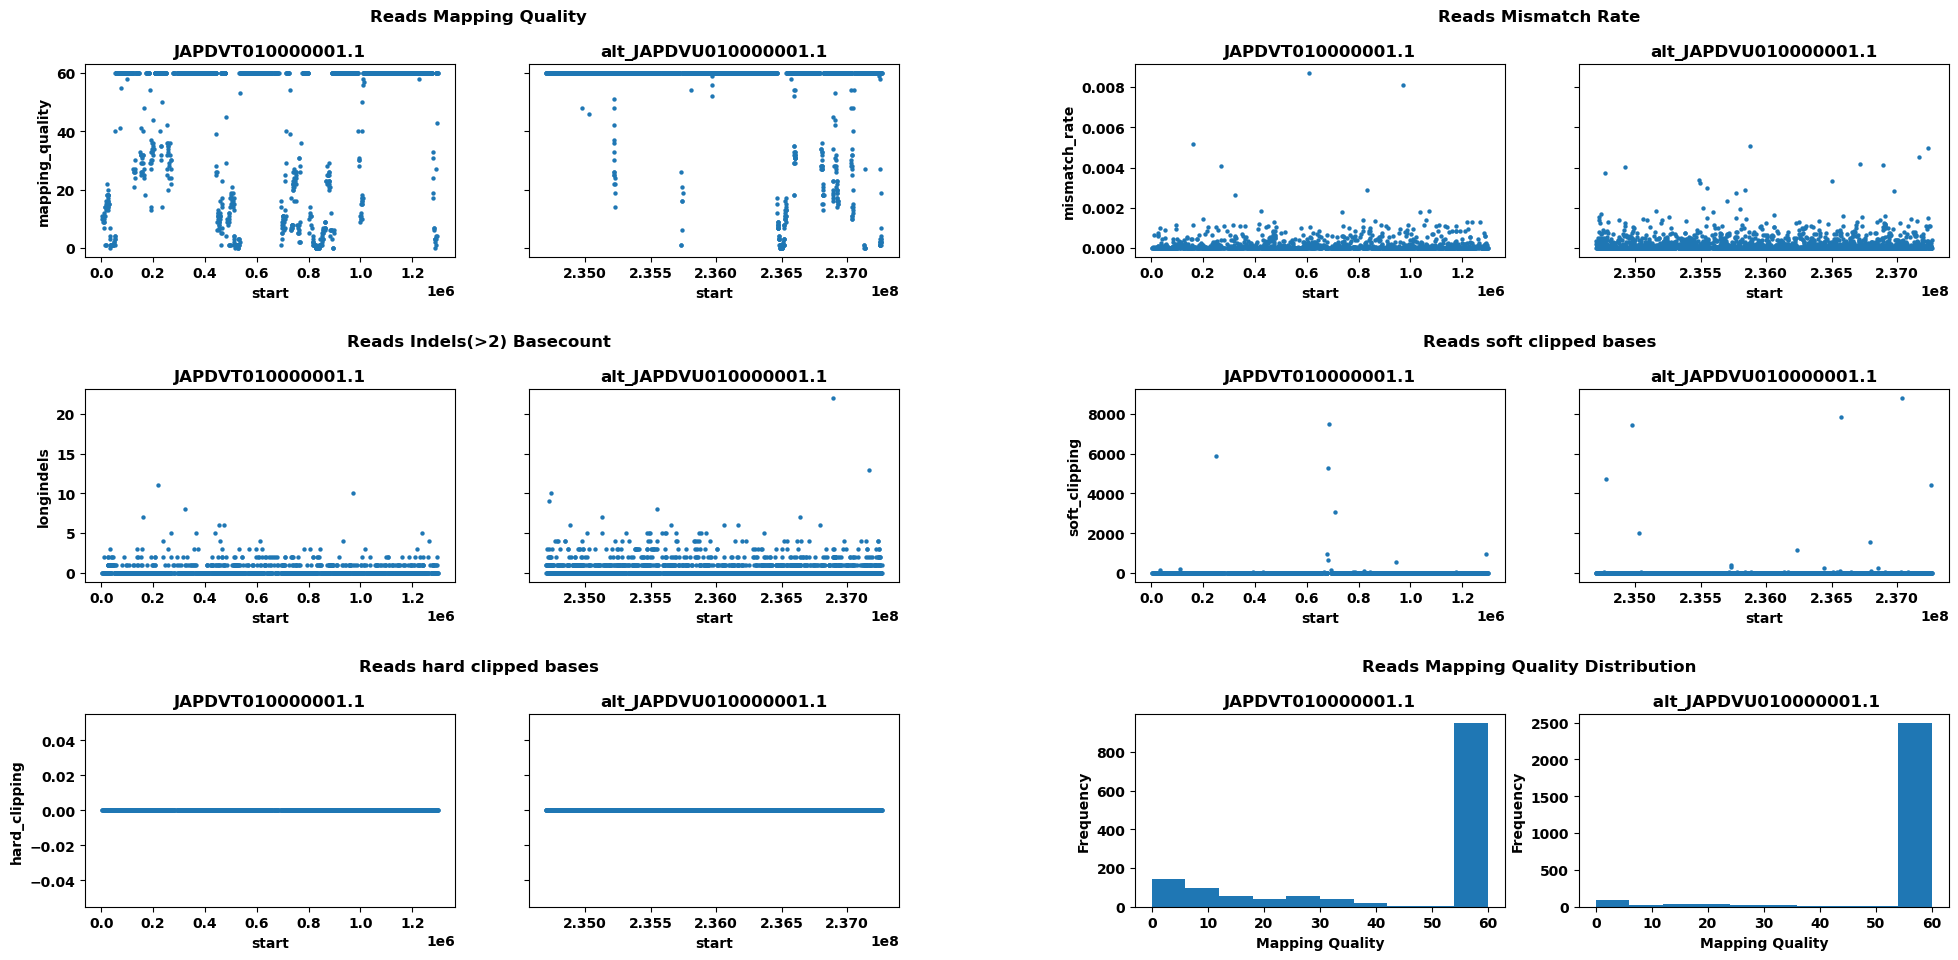

In [22]:
fig = plt.figure(figsize=(21, 9))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
subfigs = fig.subfigures(3, 2, wspace=0, hspace = 0.3)
subfigsnest1 = subfigs[0][0].subplots(1, 2, sharey=True)
subfigsnest2 = subfigs[0][1].subplots(1, 2, sharey=True)
subfigsnest3 = subfigs[1][0].subplots(1, 2, sharey=True)
subfigsnest4 = subfigs[1][1].subplots(1, 2, sharey=True)
subfigsnest5 = subfigs[2][0].subplots(1, 2, sharey=True)
subfigsnest6 = subfigs[2][1].subplots(1, 2, sharey=False)

sns.scatterplot(x='start', y='mapping_quality', data=igh_pri, palette="coolwarm", s=10, ax=subfigsnest1[0], linewidth=0)
sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri, palette="coolwarm", s=10, ax=subfigsnest2[0], linewidth=0)
sns.scatterplot(x='start', y='longindels', data=igh_pri, palette="coolwarm", s=10, ax=subfigsnest3[0], linewidth=0)
sns.scatterplot(x='start', y='soft_clipping', data=igh_pri, palette="coolwarm", s=10, ax=subfigsnest4[0], linewidth=0)
sns.scatterplot(x='start', y='hard_clipping', data=igh_pri, palette="coolwarm", s=10, ax=subfigsnest5[0], linewidth=0)

sns.scatterplot(x='start', y='mapping_quality', data=igh_alt, palette="coolwarm", s=10, ax=subfigsnest1[1], linewidth=0)
sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt, palette="coolwarm", s=10, ax=subfigsnest2[1], linewidth=0)
sns.scatterplot(x='start', y='longindels', data=igh_alt, palette="coolwarm", s=10, ax=subfigsnest3[1], linewidth=0)
sns.scatterplot(x='start', y='soft_clipping', data=igh_alt, palette="coolwarm", s=10, ax=subfigsnest4[1], linewidth=0)
sns.scatterplot(x='start', y='hard_clipping', data=igh_alt, palette="coolwarm", s=10, ax=subfigsnest5[1], linewidth=0)

subfigsnest6[0].hist(igh_pri['mapping_quality'])
subfigsnest6[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest6[0].set_xlabel('Mapping Quality')
subfigsnest6[0].set_ylabel('Frequency')

subfigsnest6[1].hist(igh_alt['mapping_quality'])
subfigsnest6[1].set_title(f'\n {chr2}', fontweight='bold')
subfigsnest6[1].set_xlabel('Mapping Quality')
subfigsnest6[1].set_ylabel('Frequency')


# Bold font for tick labels
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
subfigs[0][0].suptitle('Reads Mapping Quality', fontweight='bold', y = 1.1, x=0.5)
subfigs[0][1].suptitle('Reads Mismatch Rate', fontweight='bold', y = 1.1, x=0.51)
subfigs[1][0].suptitle('Reads Indels(>2) Basecount', fontweight='bold', y = 1.1, x=0.5)
subfigs[1][1].suptitle('Reads soft clipped bases', fontweight='bold', y = 1.1, x=0.51)
subfigs[2][0].suptitle('Reads hard clipped bases', fontweight='bold', y = 1.1, x=0.5)
subfigs[2][1].suptitle('Reads Mapping Quality Distribution', fontweight='bold', y = 1.1, x=0.5)

subfigsnest1[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest2[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest3[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest4[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest5[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest1[1].set_title(f'{chr2}', fontweight='bold')
subfigsnest2[1].set_title(f'{chr2}', fontweight='bold')
subfigsnest3[1].set_title(f'{chr2}', fontweight='bold')
subfigsnest4[1].set_title(f'{chr2}', fontweight='bold')
subfigsnest5[1].set_title(f'{chr2}', fontweight='bold')

#plt.tight_layout()
plt.savefig(f'../errorPlots/{species}/{gene}.summary.allreads.png', dpi=300, bbox_inches='tight')
plt.show()


### For reads with mapping quality 60 ONLY:

In [23]:
igh_pri60 = igh_pri[igh_pri['mapping_quality'] == 60]
igh_alt60 = igh_alt[igh_alt['mapping_quality'] == 60]

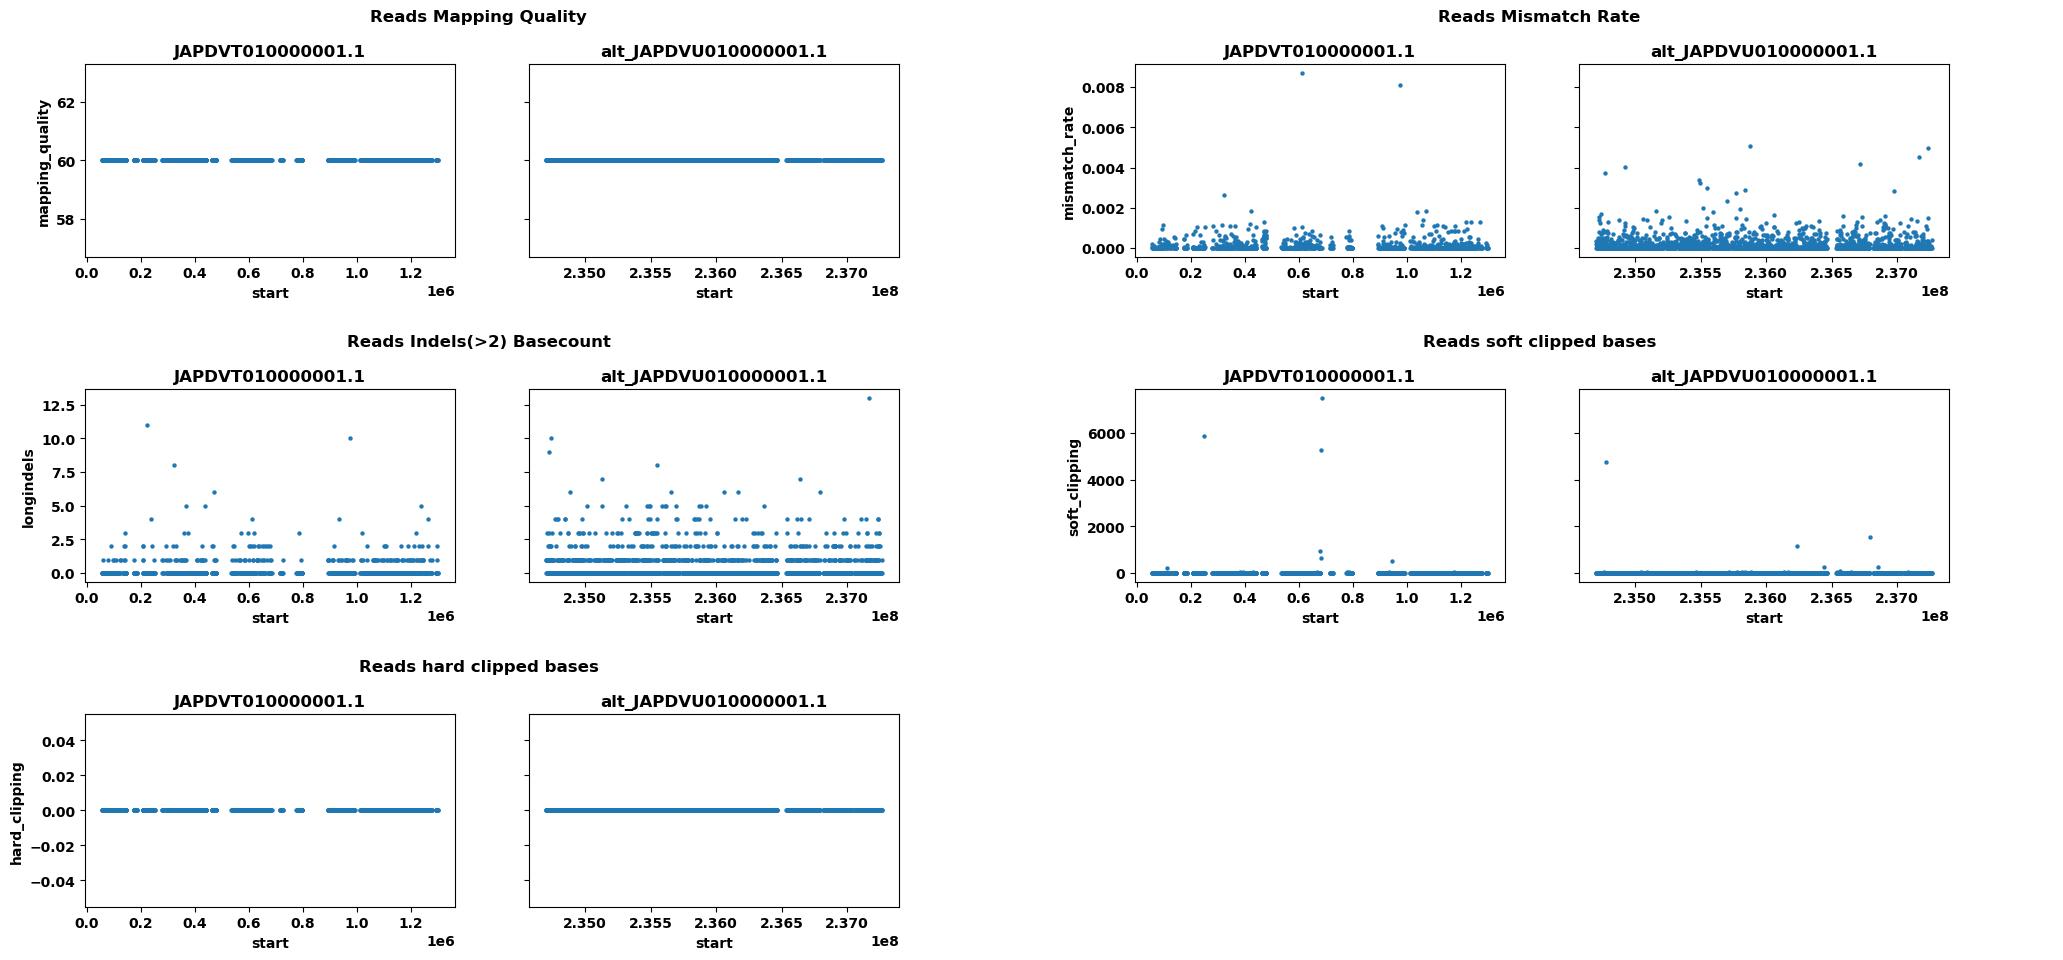

In [24]:
fig = plt.figure(figsize=(21, 9))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
subfigs = fig.subfigures(3, 2, wspace=0, hspace = 0.3)
subfigsnest1 = subfigs[0][0].subplots(1, 2, sharey=True)
subfigsnest2 = subfigs[0][1].subplots(1, 2, sharey=True)
subfigsnest3 = subfigs[1][0].subplots(1, 2, sharey=True)
subfigsnest4 = subfigs[1][1].subplots(1, 2, sharey=True)
subfigsnest5 = subfigs[2][0].subplots(1, 2, sharey=True)

sns.scatterplot(x='start', y='mapping_quality', data=igh_pri60, palette="coolwarm", s=10, ax=subfigsnest1[0], linewidth=0)
sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri60, palette="coolwarm", s=10, ax=subfigsnest2[0], linewidth=0)
sns.scatterplot(x='start', y='longindels', data=igh_pri60, palette="coolwarm", s=10, ax=subfigsnest3[0], linewidth=0)
sns.scatterplot(x='start', y='soft_clipping', data=igh_pri60, palette="coolwarm", s=10, ax=subfigsnest4[0], linewidth=0)
sns.scatterplot(x='start', y='hard_clipping', data=igh_pri60, palette="coolwarm", s=10, ax=subfigsnest5[0], linewidth=0)

sns.scatterplot(x='start', y='mapping_quality', data=igh_alt60, palette="coolwarm", s=10, ax=subfigsnest1[1], linewidth=0)
sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt60, palette="coolwarm", s=10, ax=subfigsnest2[1], linewidth=0)
sns.scatterplot(x='start', y='longindels', data=igh_alt60, palette="coolwarm", s=10, ax=subfigsnest3[1], linewidth=0)
sns.scatterplot(x='start', y='soft_clipping', data=igh_alt60, palette="coolwarm", s=10, ax=subfigsnest4[1], linewidth=0)
sns.scatterplot(x='start', y='hard_clipping', data=igh_alt60, palette="coolwarm", s=10, ax=subfigsnest5[1], linewidth=0)

    
subfigs[0][0].suptitle('Reads Mapping Quality', fontweight='bold', y = 1.1, x=0.5)
subfigs[0][1].suptitle('Reads Mismatch Rate', fontweight='bold', y = 1.1, x=0.51)
subfigs[1][0].suptitle('Reads Indels(>2) Basecount', fontweight='bold', y = 1.1, x=0.5)
subfigs[1][1].suptitle('Reads soft clipped bases', fontweight='bold', y = 1.1, x=0.51)
subfigs[2][0].suptitle('Reads hard clipped bases', fontweight='bold', y = 1.1, x=0.5)

subfigsnest1[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest2[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest3[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest4[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest5[0].set_title(f'{chr1}', fontweight='bold')
subfigsnest1[1].set_title(f'{chr2}', fontweight='bold')
subfigsnest2[1].set_title(f'{chr2}', fontweight='bold')
subfigsnest3[1].set_title(f'{chr2}', fontweight='bold')
subfigsnest4[1].set_title(f'{chr2}', fontweight='bold')
subfigsnest5[1].set_title(f'{chr2}', fontweight='bold')

#plt.tight_layout()
plt.savefig(f'../errorPlots/{species}/{gene}.summary.qv60.png', dpi=300, bbox_inches='tight')
plt.show()


In [25]:
def coverage(igh_pri, igh_alt):
    mismatchThreshold = 5
    min_position_pri = igh_pri['start'].min()
    max_position_pri = (igh_pri['start'] + igh_pri['read_length']).max()
    coverage_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    high_mismatch_coverage_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        coverage_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    zero_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        zero_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    mid_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[(igh_pri['mapping_quality'] > 0) & (igh_pri['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        mid_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    positions_pri = np.arange(min_position_pri, max_position_pri + 1)
    high_mismatch_positions_pri = positions_pri[high_mismatch_coverage_pri > mismatchThreshold]
    
    min_position_alt = igh_alt['start'].min()
    max_position_alt = (igh_alt['start'] + igh_alt['read_length']).max()
    coverage_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    high_mismatch_coverage_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[igh_alt['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        coverage_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    zero_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[igh_alt['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        zero_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    mid_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[(igh_alt['mapping_quality'] > 0) & (igh_alt['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        mid_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    positions_alt = np.arange(min_position_alt, max_position_alt + 1)
    high_mismatch_positions_alt = positions_alt[high_mismatch_coverage_alt > mismatchThreshold]
    
    high_mismatch_bool_pri = high_mismatch_coverage_pri > mismatchThreshold
    diff = np.diff(high_mismatch_bool_pri.astype(int))
    start_indices_pri = np.where(diff == 1)[0] + 1 + min_position_pri
    end_indices_pri = np.where(diff == -1)[0] + 1 + min_position_pri
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_pri[0]:
        start_indices_pri = np.insert(start_indices_pri, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_pri[-1]:
        end_indices_pri = np.append(end_indices_pri, high_mismatch_bool_pri.size)
    
    high_mismatch_bool_alt = high_mismatch_coverage_alt > mismatchThreshold
    diff = np.diff(high_mismatch_bool_alt.astype(int))
    start_indices_alt = np.where(diff == 1)[0] + 1 + min_position_alt
    end_indices_alt = np.where(diff == -1)[0] + 1 + min_position_alt
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_alt[0]:
        start_indices_alt = np.insert(start_indices_alt, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_alt[-1]:
        end_indices_alt = np.append(end_indices_alt, high_mismatch_bool_alt.size)
        
    start_break_pri = break_regions[break_regions['Chrom'] == chr1]['Start'].tolist()
    end_break_pri = break_regions[break_regions['Chrom'] == chr1]['End'].tolist()
    start_break_alt = break_regions[break_regions['Chrom'] == chr2]['Start'].tolist()
    end_break_alt = break_regions[break_regions['Chrom'] == chr2]['End'].tolist()
    return start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, start_indices_alt, end_indices_alt, start_break_alt, end_break_alt, high_mismatch_bool_alt, positions_alt, coverage_counts_alt, zero_counts_alt, min_position_alt, max_position_alt, mid_counts_pri, mid_counts_alt, high_mismatch_coverage_pri, high_mismatch_coverage_alt
    

In [26]:
start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, start_indices_alt, end_indices_alt, start_break_alt, end_break_alt, high_mismatch_bool_alt, positions_alt, coverage_counts_alt, zero_counts_alt, min_position_alt, max_position_alt, mid_counts_pri, mid_counts_alt,  high_mismatch_coverage_pri, high_mismatch_coverage_alt = coverage(igh_pri, igh_alt)

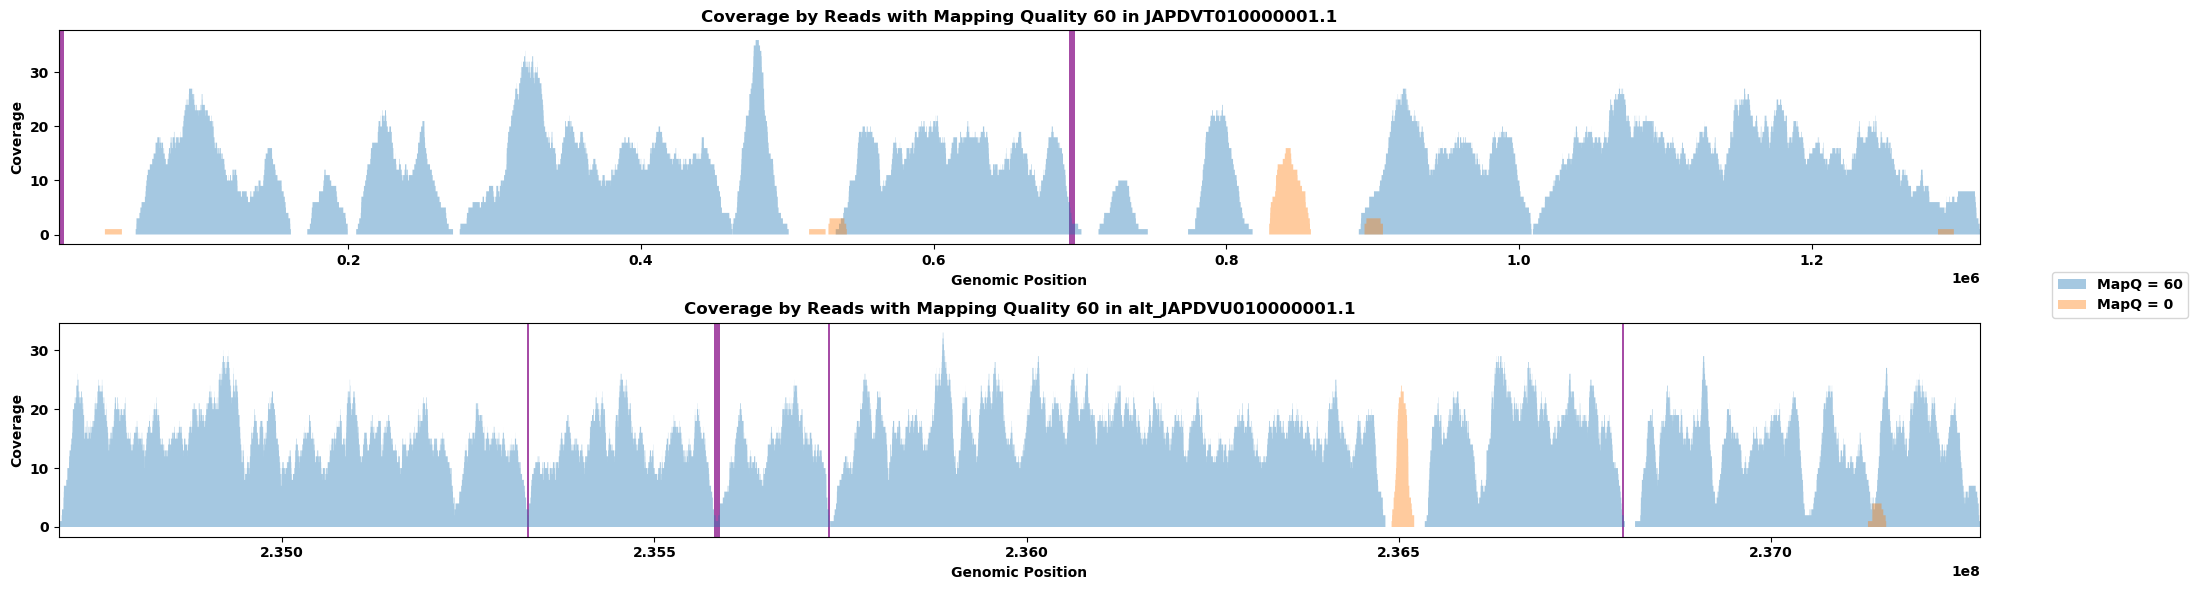

In [27]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))
# Plot the results
for start, end in zip(start_indices_pri, end_indices_pri):
    axes[0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_pri, end_break_pri):
    if end - start < 2000:
        axes[0].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[0].axvspan(start, end, facecolor='purple', alpha=0.7)
axes[0].fill_between(positions_pri, coverage_counts_pri, step="pre", alpha=0.4, label='MapQ = 60')
axes[0].fill_between(positions_pri, zero_counts_pri, step="pre", alpha=0.4, label='MapQ = 0')
axes[0].set_title(f'Coverage by Reads with Mapping Quality 60 in {chr1}', fontweight='bold')
axes[0].set_xlabel('Genomic Position', fontweight='bold')
axes[0].set_ylabel('Coverage', fontweight='bold')
axes[0].set_xlim(min_position_pri, max_position_pri)
#axes[0].set_xticks([])


for start, end in zip(start_indices_alt, end_indices_alt):
    axes[1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt, end_break_alt):
    if end - start < 2000:
        axes[1].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[1].axvspan(start, end, facecolor='purple', alpha=0.7)
axes[1].fill_between(positions_alt, coverage_counts_alt, step="pre", alpha=0.4)
axes[1].fill_between(positions_alt, zero_counts_alt, step="pre", alpha=0.4)
axes[1].set_title(f'Coverage by Reads with Mapping Quality 60 in {chr2}', fontweight='bold')
axes[1].set_xlabel('Genomic Position', fontweight='bold')
axes[1].set_ylabel('Coverage', fontweight='bold')
axes[1].set_xlim(min_position_alt, max_position_alt)
#axes[1].set_xticks([]) 


fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.savefig(f'../errorPlots/{species}/{gene}.readcoverage.qv60+0.png', dpi=300, bbox_inches='tight')
plt.show()

## Reads other than MAPQ 60 or 0

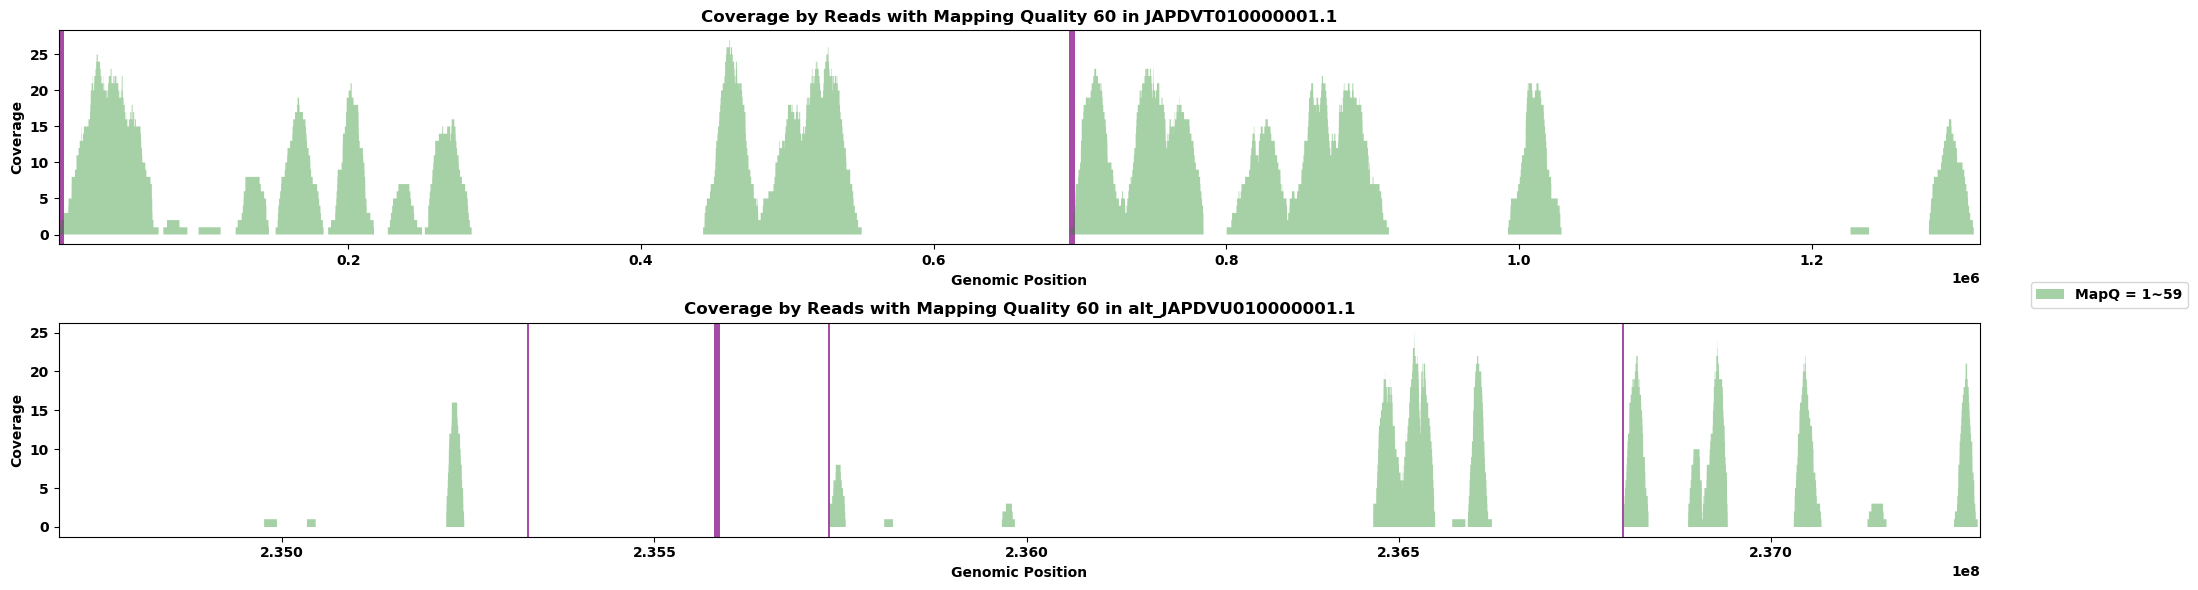

In [28]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))
# Plot the results
for start, end in zip(start_indices_pri, end_indices_pri):
    axes[0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_pri, end_break_pri):
    if end - start < 2000:
        axes[0].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[0].axvspan(start, end, facecolor='purple', alpha=0.7)
axes[0].fill_between(positions_pri, mid_counts_pri, step="pre", alpha=0.4, label='MapQ = 1~59', facecolor='forestgreen')
axes[0].set_title(f'Coverage by Reads with Mapping Quality 60 in {chr1}', fontweight='bold')
axes[0].set_xlabel('Genomic Position')
axes[0].set_ylabel('Coverage')
axes[0].set_xlim(min_position_pri, max_position_pri)
#axes[0].set_xticks([])


for start, end in zip(start_indices_alt, end_indices_alt):
    axes[1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt, end_break_alt):
    if end - start < 2000:
        axes[1].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[1].axvspan(start, end, facecolor='purple', alpha=0.7)
axes[1].fill_between(positions_alt, mid_counts_alt, step="pre", alpha=0.4, facecolor='forestgreen')
axes[1].set_title(f'Coverage by Reads with Mapping Quality 60 in {chr2}', fontweight='bold')
axes[1].set_xlabel('Genomic Position')
axes[1].set_ylabel('Coverage')
axes[1].set_xlim(min_position_alt, max_position_alt)
#axes[1].set_xticks([]) 


fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.savefig(f'../errorPlots/{species}/{gene}.readcoverage.qv1-59.png', dpi=300, bbox_inches='tight')
plt.show()

## All Together

### Heterozygousity Analysis

In [29]:
"""
het = pd.read_csv(f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/similarity/{species}/{species}.{gene}.msa", sep="\t", names=['Query', 'Subject', 'identity', 'alignment length', 'mismatches', 'gap openings', 'q.start', 'q.end', 's.start', 's.end', 'e-value', 'bit score'])
het = het.iloc[1:]
het = het[(het['identity']>= 99.8) & (het['alignment length']>= 100000)]
het = het.drop_duplicates(subset=['q.start', 'q.end', 's.start', 's.end'])
het = het.sort_values(by=['q.start'])
priHet = list(zip(het['q.start'], het['q.end']))
altHet = list(zip(het['s.start'], het['s.end']))
"""

'\nhet = pd.read_csv(f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/similarity/{species}/{species}.{gene}.msa", sep="\t", names=[\'Query\', \'Subject\', \'identity\', \'alignment length\', \'mismatches\', \'gap openings\', \'q.start\', \'q.end\', \'s.start\', \'s.end\', \'e-value\', \'bit score\'])\nhet = het.iloc[1:]\nhet = het[(het[\'identity\']>= 99.8) & (het[\'alignment length\']>= 100000)]\nhet = het.drop_duplicates(subset=[\'q.start\', \'q.end\', \'s.start\', \'s.end\'])\nhet = het.sort_values(by=[\'q.start\'])\npriHet = list(zip(het[\'q.start\'], het[\'q.end\']))\naltHet = list(zip(het[\'s.start\'], het[\'s.end\']))\n'

In [30]:
"""
from matplotlib.patches import ConnectionPatch

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))
# Plot the results
for start, end in zip(start_indices_pri, end_indices_pri):
    axes[0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_pri, end_break_pri):
    if end - start < 2000:
        axes[0].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[0].axvspan(start, end, facecolor='purple', alpha=0.7)
#for start, end in pri_continuous_intervals:
#    axes[0].axvspan(start+chr1_min, end+chr1_min, color='grey', alpha=0.5)
axes[0].fill_between(positions_pri, coverage_counts_pri, step="pre", alpha=0.4, label='MapQ = 60')
axes[0].fill_between(positions_pri, zero_counts_pri, step="pre", alpha=0.4, label='MapQ = 0')
axes[0].fill_between(positions_pri, mid_counts_pri, step="pre", alpha=0.4, label='MapQ = 1~59')
axes[0].set_title(f'Coverage by Reads with Mapping Quality 60 in {chr1}', fontweight='bold')
axes[0].set_xlabel('Genomic Position')
axes[0].set_ylabel('Coverage')
axes[0].set_xlim(min_position_pri, max_position_pri)
#axes[0].set_xticks([])


for start, end in zip(start_indices_alt, end_indices_alt):
    axes[1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt, end_break_alt):
    if end - start < 2000:
        axes[1].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[1].axvspan(start, end, facecolor='purple', alpha=0.7)
#for start, end in alt_continuous_intervals:
#    axes[1].axvspan(start+chr2_min, end+chr2_min, color='grey', alpha=0.5)
axes[1].fill_between(positions_alt, coverage_counts_alt, step="pre", alpha=0.4)
axes[1].fill_between(positions_alt, zero_counts_alt, step="pre", alpha=0.4)
axes[1].fill_between(positions_alt, mid_counts_alt, step="pre", alpha=0.4)
axes[1].set_title(f'Coverage by Reads with Mapping Quality 60 in {chr2}', fontweight='bold')
axes[1].set_xlabel('Genomic Position')
axes[1].set_ylabel('Coverage')
axes[1].set_xlim(min_position_alt, max_position_alt)
#axes[1].set_xticks([]) 


for (x1, x2), (y1, y2) in zip(priHet, altHet):
    # Highlight regions in ax1 and ax2
    if (y2+chr2_min <= max_position_alt) & (y1+chr2_min <= max_position_alt):
        axes[0].axvspan(x1+chr1_min, x2+chr1_min, color='grey', alpha=0.3)
        axes[1].axvspan(y1+chr2_min, y2+chr2_min, color='grey', alpha=0.3)
    
        # Connect the end of the first highlight region in ax1 to the start of the first highlight region in ax2
        con_patch1 = ConnectionPatch(xyA=(x1+chr1_min, -2), xyB=(y1+chr2_min, 102), coordsA=axes[0].transData, coordsB=axes[1].transData,
                                  color="black")
        fig.add_artist(con_patch1)
    
        # Connect the end of the first highlight region in ax1 to the start of the second highlight region in ax2
        con_patch2 = ConnectionPatch(xyA=(x2+chr1_min, -2), xyB=(y2+chr2_min, 102), coordsA=axes[0].transData, coordsB=axes[1].transData,
                                color="black")
        fig.add_artist(con_patch2)
    

fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.savefig(f'../errorPlots/{species}/{gene}.readcoverage.all.het.png', dpi=300, bbox_inches='tight')
plt.show()
"""

'\nfrom matplotlib.patches import ConnectionPatch\n\nplt.rcParams["font.weight"] = "bold"\nplt.rcParams["axes.labelweight"] = "bold"\nfig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))\n# Plot the results\nfor start, end in zip(start_indices_pri, end_indices_pri):\n    axes[0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor=\'rosybrown\', alpha=0.2, zorder=0)  \nfor start, end in zip(start_break_pri, end_break_pri):\n    if end - start < 2000:\n        axes[0].axvspan(start-1005, end+1005, facecolor=\'purple\', alpha=0.7)\n    else: \n        axes[0].axvspan(start, end, facecolor=\'purple\', alpha=0.7)\n#for start, end in pri_continuous_intervals:\n#    axes[0].axvspan(start+chr1_min, end+chr1_min, color=\'grey\', alpha=0.5)\naxes[0].fill_between(positions_pri, coverage_counts_pri, step="pre", alpha=0.4, label=\'MapQ = 60\')\naxes[0].fill_between(positions_pri, zero_counts_pri, step="pre", alpha=0.4, label=\'MapQ = 0\')\naxes[0].fill_

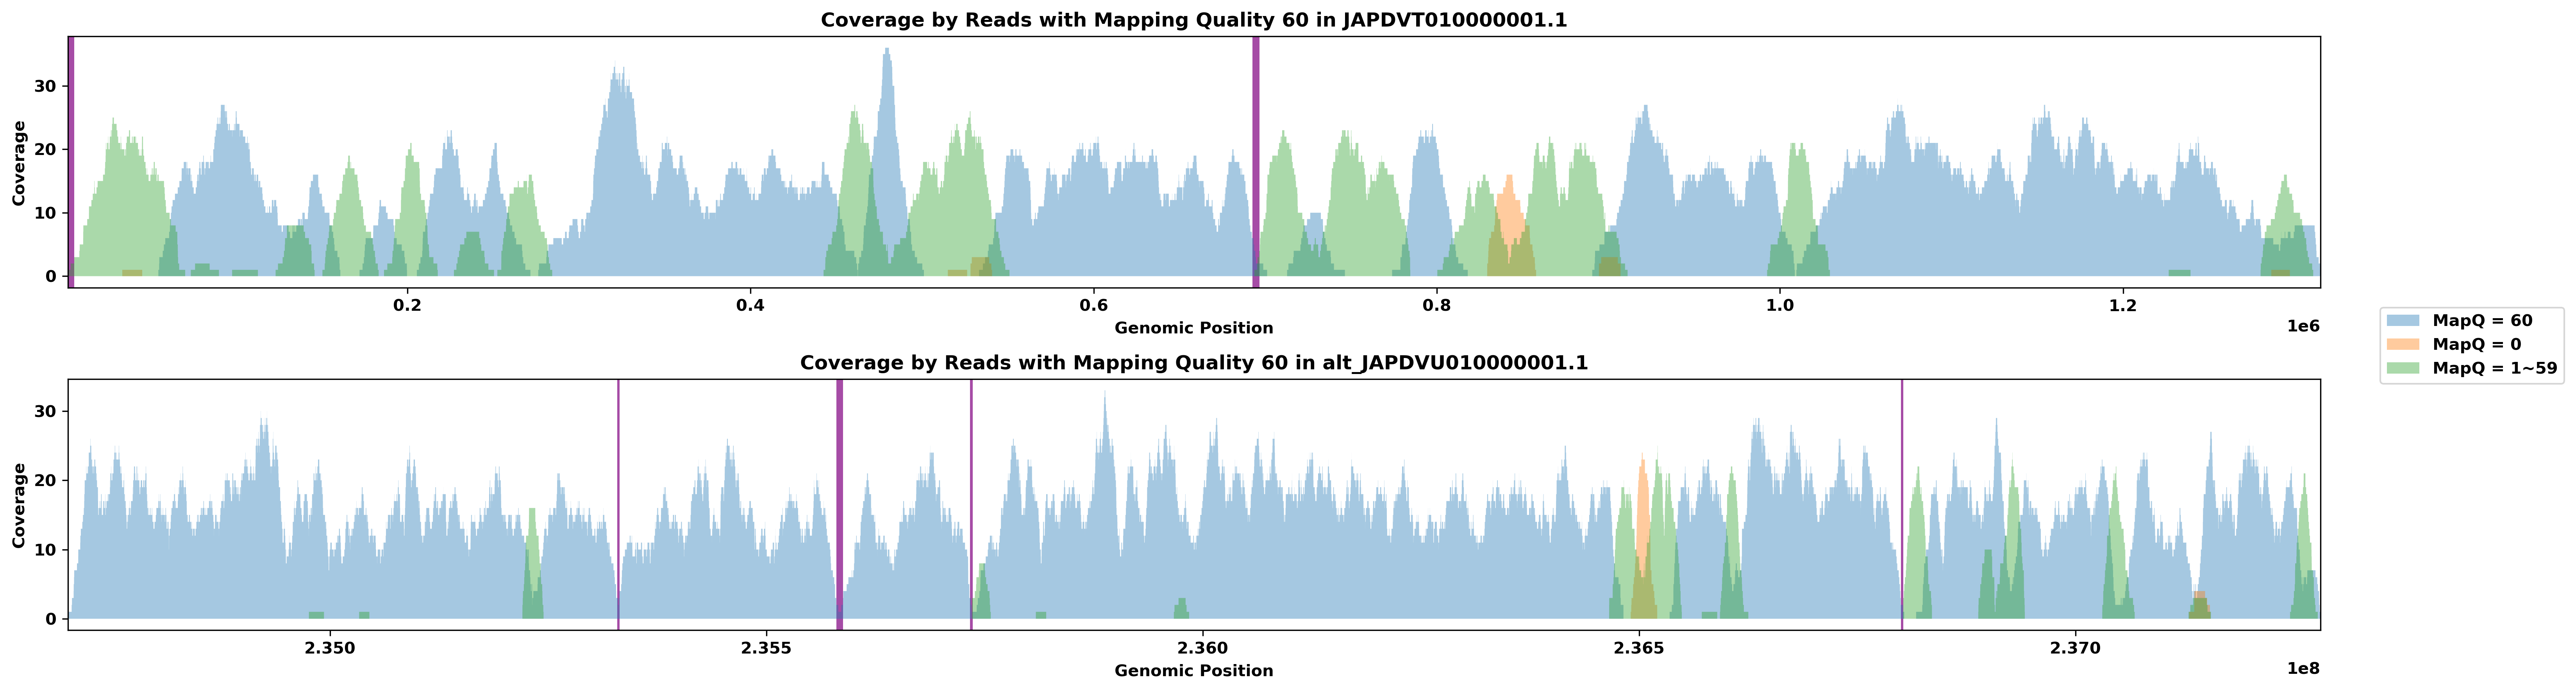

In [31]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6), dpi=300)
# Plot the results
for start, end in zip(start_indices_pri, end_indices_pri):
    axes[0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_pri, end_break_pri):
    if end - start < 2000:
        axes[0].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[0].axvspan(start, end, facecolor='purple', alpha=0.7)
#for start, end in pri_continuous_intervals:
#    axes[0].axvspan(start+chr1_min, end+chr1_min, color='grey', alpha=0.5)
axes[0].fill_between(positions_pri, coverage_counts_pri, step="pre", alpha=0.4, label='MapQ = 60')
axes[0].fill_between(positions_pri, zero_counts_pri, step="pre", alpha=0.4, label='MapQ = 0')
axes[0].fill_between(positions_pri, mid_counts_pri, step="pre", alpha=0.4, label='MapQ = 1~59')
axes[0].set_title(f'Coverage by Reads with Mapping Quality 60 in {chr1}', fontweight='bold')
axes[0].set_xlabel('Genomic Position')
axes[0].set_ylabel('Coverage')
axes[0].set_xlim(min_position_pri, max_position_pri)
#axes[0].set_xticks([])


chr1_min = min_position_pri
chr1_max = max_position_pri
chr2_min = min_position_alt
chr2_max = max_position_alt 

for start, end in zip(start_indices_alt, end_indices_alt):
    axes[1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt, end_break_alt):
    if end - start < 2000:
        axes[1].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[1].axvspan(start, end, facecolor='purple', alpha=0.7)
#for start, end in alt_continuous_intervals:
#    axes[1].axvspan(start+chr2_min, end+chr2_min, color='grey', alpha=0.5)
axes[1].fill_between(positions_alt, coverage_counts_alt, step="pre", alpha=0.4)
axes[1].fill_between(positions_alt, zero_counts_alt, step="pre", alpha=0.4)
axes[1].fill_between(positions_alt, mid_counts_alt, step="pre", alpha=0.4)
axes[1].set_title(f'Coverage by Reads with Mapping Quality 60 in {chr2}', fontweight='bold')
axes[1].set_xlabel('Genomic Position')
axes[1].set_ylabel('Coverage')
axes[1].set_xlim(min_position_alt, max_position_alt)
#axes[1].set_xticks([]) 

fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.savefig(f'../errorPlots/{species}/{gene}.readcoverage.all.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
min_position_alt, max_position_alt

(234699468, 237280882)

## Basepair level accuracy

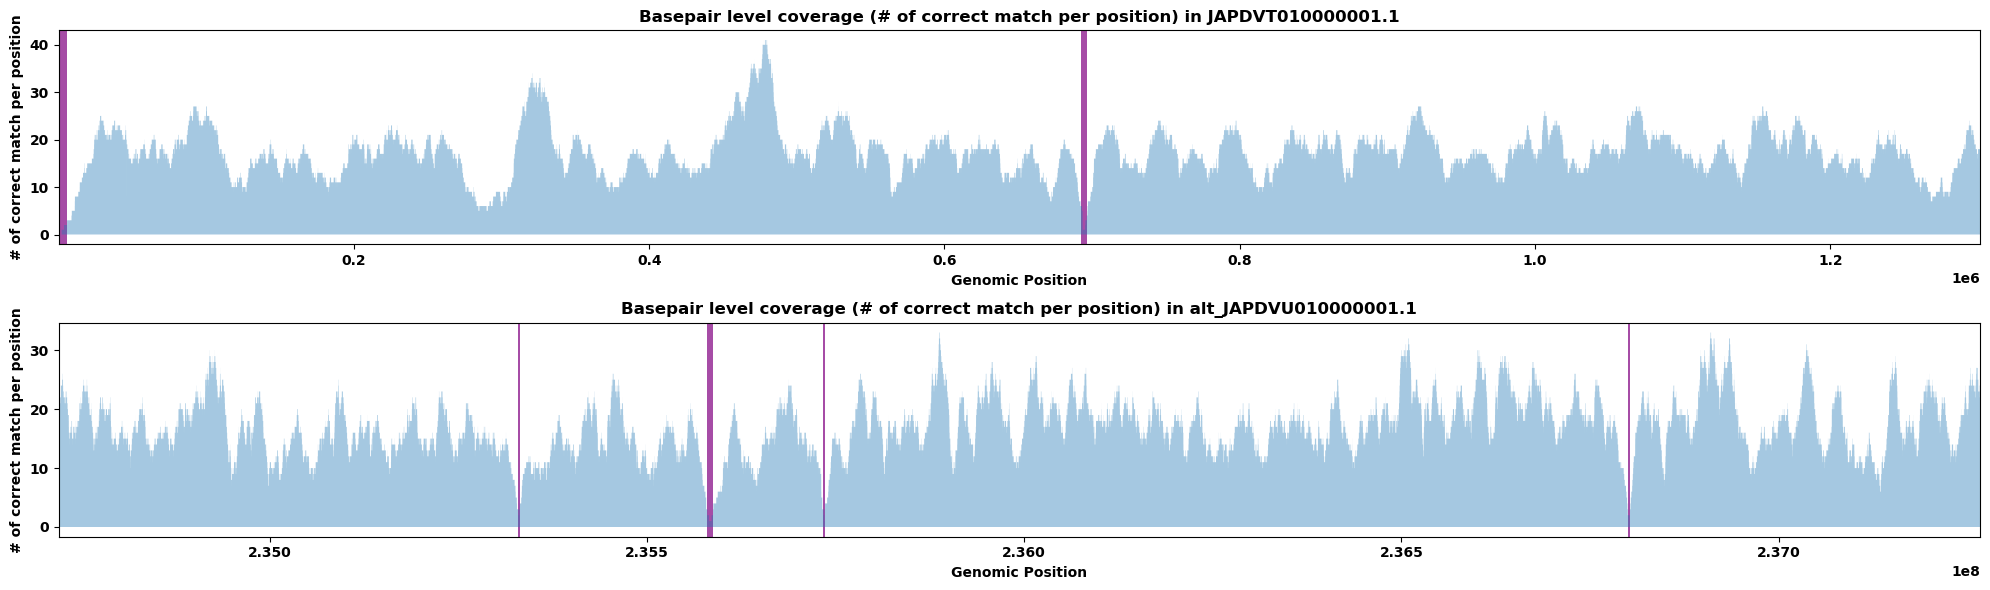

In [32]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))
for start, end in zip(start_indices_pri, end_indices_pri):
    axes[0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_pri, end_break_pri):
    if end - start < 2000:
        axes[0].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[0].axvspan(start, end, facecolor='purple', alpha=0.7)

for start, end in zip(start_indices_alt, end_indices_alt):
    axes[1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt, end_break_alt):
    if end - start < 2000:
        axes[1].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[1].axvspan(start, end, facecolor='purple', alpha=0.7)
axes[0].fill_between(pri_pileup['Pos'], pri_pileup['Correct'], step="pre", alpha=0.4)
axes[1].fill_between(alt_pileup['Pos'], alt_pileup['Correct'], step="pre", alpha=0.4)
axes[0].set_title(f'Basepair level coverage (# of correct match per position) in {chr1}', fontweight='bold')
axes[1].set_title(f'Basepair level coverage (# of correct match per position) in {chr2}', fontweight='bold')
axes[0].set_xlabel('Genomic Position')
axes[0].set_ylabel('# of correct match per position')
axes[1].set_xlabel('Genomic Position')
axes[1].set_ylabel('# of correct match per position')
plt.tight_layout()
axes[0].margins(x=0)
axes[1].margins(x=0)
plt.savefig(f'../errorPlots/{species}/{gene}.basecoverage.numCorrect.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
pri_pileup_100 = pri_pileup[pri_pileup['PercentCorrect'] >= 98]
pri_pileup_100['Bin_Start_Pos'] = (pri_pileup_100['Pos'] // 10000) * 10000
bin_count = pri_pileup_100.groupby('Bin_Start_Pos').size()
bin_count = pd.DataFrame(bin_count, columns=["zeroCount"])
bin_count["Zero Error"] = bin_count["zeroCount"]/10000*100
bin_count=bin_count.reset_index()

alt_pileup_100 = alt_pileup[alt_pileup['PercentCorrect'] >= 98]
alt_pileup_100['Bin_Start_Pos'] = (alt_pileup_100['Pos'] // 10000) * 10000
alt_bin_count = alt_pileup_100.groupby('Bin_Start_Pos').size()
alt_bin_count = pd.DataFrame(alt_bin_count, columns=["zeroCount"])
alt_bin_count["Zero Error"] = alt_bin_count["zeroCount"]/10000*100
alt_bin_count=alt_bin_count.reset_index()

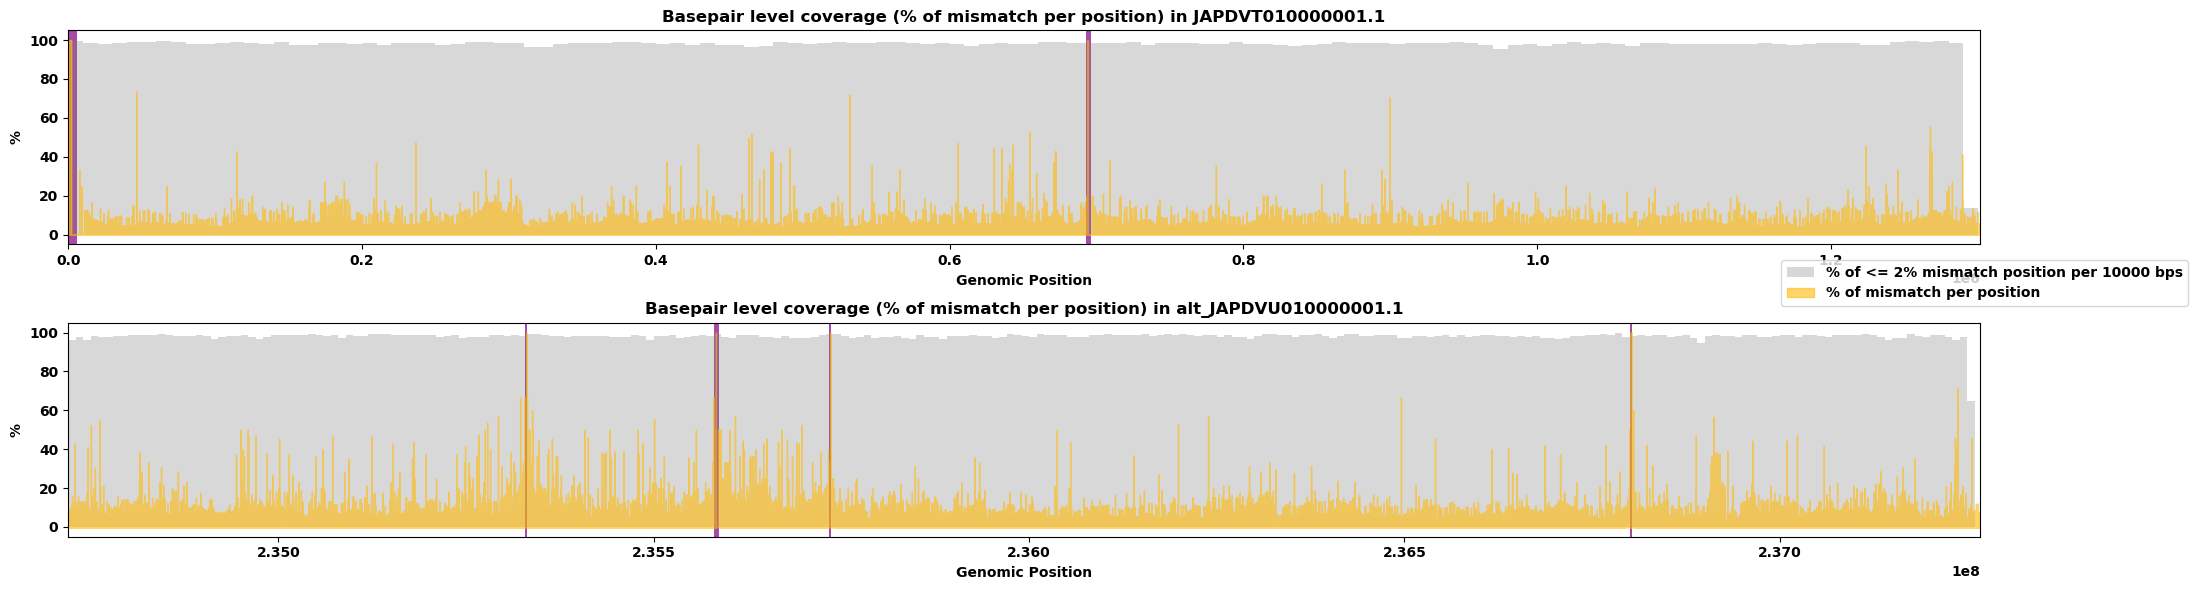

In [38]:
#import matplotlib as mpl
#mpl.rcParams['agg.path.chunksize'] = 100000000
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))
for start, end in zip(start_indices_pri, end_indices_pri):
    axes[0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='#5e503f', alpha=0.3, zorder=0)  
for start, end in zip(start_break_pri, end_break_pri):
    if end - start < 2000:
        axes[0].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[0].axvspan(start, end, facecolor='purple', alpha=0.7)

for start, end in zip(start_indices_alt, end_indices_alt):
    axes[1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt, end_break_alt):
    if end - start < 2000:
        axes[1].axvspan(start-1005, end+1005, facecolor='purple', alpha=0.7)
    else: 
        axes[1].axvspan(start, end, facecolor='purple', alpha=0.7)
axes[0].fill_between(bin_count['Bin_Start_Pos'], bin_count["Zero Error"], step="pre", alpha=0.3, facecolor = 'grey', zorder=1)
axes[0].fill_between(pri_pileup['Pos'], 100 - pri_pileup['PercentCorrect'], step="pre", alpha=0.6, color = '#ffba08', zorder=2)
axes[1].fill_between(alt_bin_count['Bin_Start_Pos'], alt_bin_count['Zero Error'], step="pre", alpha=0.3, facecolor = 'grey', zorder=1, label='% of <= 2% mismatch position per 10000 bps')
axes[1].fill_between(alt_pileup['Pos'], 100 - alt_pileup['PercentCorrect'], step="pre", alpha=0.6, color = '#ffba08', zorder=2, label='% of mismatch per position')
axes[0].set_title(f'Basepair level coverage (% of mismatch per position) in {chr1}', fontweight='bold')
axes[1].set_title(f'Basepair level coverage (% of mismatch per position) in {chr2}', fontweight='bold')
axes[0].set_xlabel('Genomic Position')
axes[0].set_ylabel('%')
axes[1].set_xlabel('Genomic Position')
axes[1].set_ylabel('%')
fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.52))
plt.tight_layout()
axes[0].margins(x=0)
axes[1].margins(x=0)
plt.savefig(f'../errorPlots/{species}/{gene}.basecoverage.PerCorrect.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
pri_pileup[pri_pileup["Pos"] >= 183660000]

,Chrom,Pos,Correct,PercentCorrect,Depth


pdf = PDF()
pdf.add_page()
pdf.set_font("Arial", size = 12)

# Adding a text block
if corrected == False:
    text = f"Assembly source from {source}, before correction"
else:
    text = f"Assembly source from {source}, after correction"
pdf.cell(200, 10, txt = text, ln = True, align = 'L')

# Calculate next Y position to avoid overlap
next_y = pdf.get_y()  # Adjust 2 or more for spacing

# Adding an image
image_path = '../errorStats/mPanPan1/IGH_alt_rolling_avg_correct_matches.png'
pdf.image(image_path, x = 10, y = next_y, w = 100)

# After the image, adjust the Y position again for the next block of content
pdf.set_y(pdf.get_y() + _mid)  # Adjust _mid or more based on the image height

# Add more text after the image
pdf.cell(200, 10, txt = "Text after the image", ln = True, align = 'L')
# Save the pdf with name .pdf
pdf.output("../errorStats/mPanPan1/output.pdf")